## Import Library

In [13]:
%matplotlib notebook
import random
import sys
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# import seaborn as sns
import time
import csv
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


## Loading Data

In [35]:
my_data_x = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191021/mag_data_x.csv', delimiter=',')
my_data_y = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191021/mag_data_y.csv', delimiter=',')
my_data_z = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191021/mag_data_z.csv', delimiter=',')


# Load MagImage for deciding that where the data is and getting the width and Height of map
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data
gray_img = load_image('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191021/mag_map.png')
(g_height,g_width, channel_size)=gray_img.shape

ground_truth_mag_img_x = np.zeros([g_height, g_width])
ground_truth_mag_img_y = np.zeros([g_height, g_width])
ground_truth_mag_img_z = np.zeros([g_height, g_width])

mag_training_data_xy = []
mag_training_data_z = []

max_value = -99
min_value = 99
abs_min_value = 99

for i in range(g_height):
    for j in range(g_width):
        if gray_img[i][j][0]!=0.0:
            if my_data_x[i][j]>max_value:
                max_value = my_data_x[i][j]
            if my_data_y[i][j]>max_value:
                max_value = my_data_y[i][j]
            if my_data_z[i][j]>max_value:
                max_value = my_data_z[i][j]
                
            if my_data_x[i][j]<min_value:
                min_value = my_data_x[i][j]
            if my_data_y[i][j]<min_value:
                min_value = my_data_y[i][j]
            if my_data_z[i][j]<min_value:
                min_value = my_data_z[i][j]
            
            if abs(my_data_x[i][j])<abs_min_value:
                abs_min_value = abs(my_data_x[i][j])
            if abs(my_data_y[i][j])<abs_min_value:
                abs_min_value = abs(my_data_y[i][j])
            if abs(my_data_z[i][j])<abs_min_value:
                abs_min_value = abs(my_data_z[i][j])
                
#             Generate Ground Truth Image
            ground_truth_mag_img_x[i][j] = my_data_x[i][j]
            ground_truth_mag_img_y[i][j] = my_data_y[i][j]
            ground_truth_mag_img_z[i][j] = my_data_z[i][j]

#             Generate training data vec(x,y) & vec(z)
            m_mag_vec = []
            m_mag_vec.append(my_data_x[i][j])
            m_mag_vec.append(my_data_y[i][j])
            m_mag_vec.append(my_data_z[i][j])
            mag_training_data_xy.append([j, i]) # (width, height)
            mag_training_data_z.append(m_mag_vec)
            
mag_training_data_xy = np.asarray(mag_training_data_xy)
mag_training_data_z = np.asarray(mag_training_data_z)
data_size = mag_training_data_z.shape[0]
# print('abs minimal value: ', abs_min_value)

In [36]:
my_data_x.shape

(144, 101)

## Define Functions may used later

In [37]:
def calculate_dis(current_pos, data_pos):
    return math.hypot((current_pos[0]-data_pos[0]), current_pos[1]-data_pos[1])

def my_gp(training_xy, training_z, test_xy):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    start_time = time.time()
    gp.fit(training_xy, training_z)
    print("---Pred: %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    y_pred, sigma = gp.predict(test_xy, return_std=True)
    print("---Fit:  %s seconds ---" % (time.time() - start_time))
    y_pred = y_pred
    return y_pred, sigma

def generate_test_data(training_xy):
    test_data_range_x =np.linspace(0, g_width-1, g_width)
    test_data_range_y =np.linspace(0, g_height-1, g_height)
    
    test_xy = np.zeros([g_width*g_height,2])
    for m in range(g_height):
        for n in range(g_width):
            test_xy[m*g_width+n][0] = test_data_range_x[n]
            test_xy[m*g_width+n][1] = test_data_range_y[m]
    return test_xy, g_width, g_height

def mark_unknown_area(OneD_pred_map, mark_value):
    output = np.zeros(0)

    for i in range(g_height):
        for j in range(g_width):
            if gray_img[i][j][0] ==0.0:
                output = np.append(output, mark_value-0.5)
            else:
                output = np.append(output, OneD_pred_map[i*g_width+j])
    return output
    
def show_predic(test_xy, pred_z,m_axis):
    fig, ax = plt.subplots()
    _min = min_value
    _max = max_value
    sc = plt.scatter(test_xy[:,0], test_xy[:,1], c=pred_z, cmap='rainbow', vmin = _min, vmax = _max)
    # plt.plot(mag_training_data_xy[:,0], mag_training_data_xy[:,1], 'ko')
    # for i in range(len(mag_training_data_z)):
    #     ax.annotate(np.round(mag_training_data_z[i],3), xy=(mag_training_data_xy[i][0],mag_training_data_xy[i][1]), color='black', 
    #             xytext=(5,5), textcoords="offset points")
    file_path = "/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/"
    filename = file_path+"scikit_GP_result_"+m_axis
    plt.colorbar()
    plt.savefig(filename)
    plt.show()

## Deploy

In [38]:
test_xy, data_x_size, data_y_size = generate_test_data(mag_training_data_xy)

mag_x_pred, mag_x_sigma = my_gp(mag_training_data_xy, mag_training_data_z[:,0], test_xy)
mag_y_pred, mag_y_sigma = my_gp(mag_training_data_xy, mag_training_data_z[:,1], test_xy)
mag_z_pred, mag_z_sigma = my_gp(mag_training_data_xy, mag_training_data_z[:,2], test_xy)

my_draw_test_data_x = test_xy[:,0].reshape(data_x_size*data_y_size,1)
my_draw_test_data_y = test_xy[:,1].reshape(data_x_size*data_y_size,1)
my_test_predict_zx = mag_x_pred.reshape(data_x_size*data_y_size,1)
my_test_predict_zy = mag_y_pred.reshape(data_x_size*data_y_size,1)
my_test_predict_zz = mag_z_pred.reshape(data_x_size*data_y_size,1)

# # fig, ax = plt.subplots()
# # _min, _max = np.amin(mag_training_data_z), np.amax(mag_training_data_z)
# # sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
# # plt.colorbar()



---Pred: 71.76908421516418 seconds ---
---Fit:  2.0979390144348145 seconds ---
---Pred: 66.95751571655273 seconds ---
---Fit:  2.1508283615112305 seconds ---
---Pred: 69.94941926002502 seconds ---
---Fit:  2.054603099822998 seconds ---


<IPython.core.display.Javascript object>


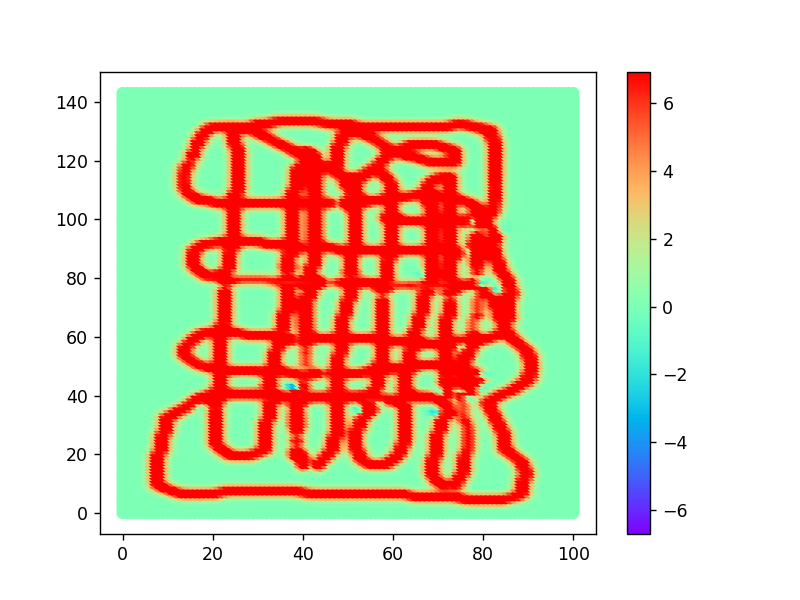

<IPython.core.display.Javascript object>


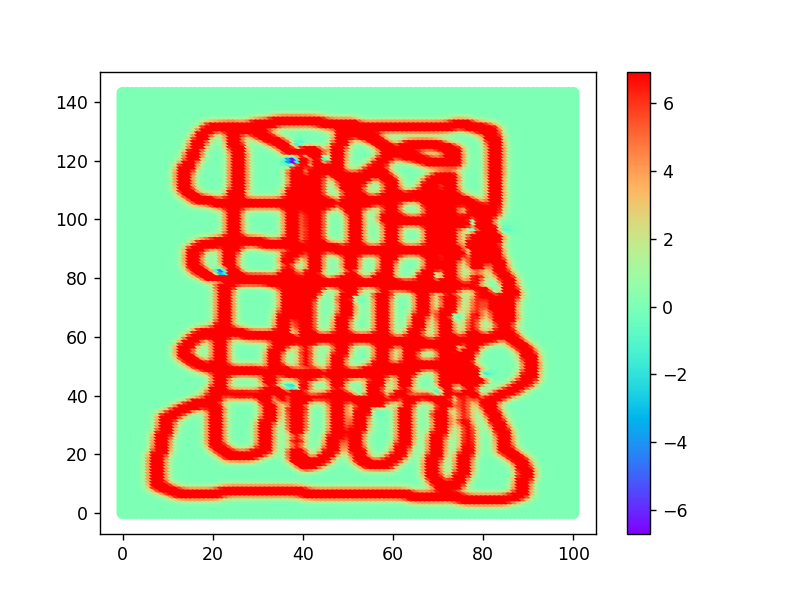

<IPython.core.display.Javascript object>


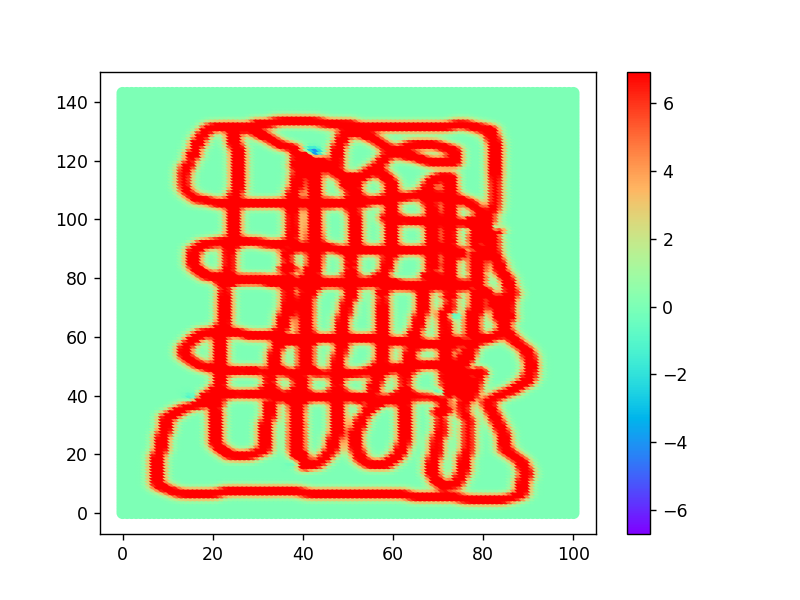

In [39]:
# f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey = True)
# _min, _max = np.amin(my_test_predict_zx), np.amax(my_test_predict_zx)
# sc = axes[0].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zx, cmap='rainbow', vmin = _min, vmax = _max)
# _min, _max = np.amin(my_test_predict_zy), np.amax(my_test_predict_zy)
# axes[1].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zy, cmap='rainbow', vmin = _min, vmax = _max)
# _min, _max = np.amin(my_test_predict_zz), np.amax(my_test_predict_zz)
# axes[2].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
# f.colorbar(sc)
show_predic(test_xy, mag_x_pred, 'x')
show_predic(test_xy, mag_y_pred, 'y')
show_predic(test_xy, mag_z_pred, 'z')

In [40]:
mag_x_pred = mag_x_pred.reshape(g_height, g_width)
mag_y_pred = mag_y_pred.reshape(g_height, g_width)
mag_z_pred = mag_z_pred.reshape(g_height, g_width)

def remove_none_detection_area(mag_pred):
    for i in range(g_height):
        for j in range(g_width):
            if abs(mag_pred[i][j]) < abs_min_value*0.1:
                mag_pred[i][j] = 0.0
    return mag_pred

mag_x_pred = remove_none_detection_area(mag_x_pred)
mag_y_pred = remove_none_detection_area(mag_y_pred)
mag_z_pred = remove_none_detection_area(mag_z_pred)

In [8]:
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_x.csv", mag_x_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_y.csv", mag_y_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_z.csv", mag_z_pred, delimiter=",")


# Calculate Mean Square Error

In [11]:
# error = 0

# for i in range(g_height):
#     for j in range(g_width):
#         if gray_img[i][j][0]!=0.0:
#             error = error + abs(ground_truth_mag_img_x[i][j] - mag_x_pred[i][j])
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(ground_truth_mag_img_x,mag_x_pred) 
print('X axis average error: ', MSE)
MSE = mean_squared_error(ground_truth_mag_img_y,mag_y_pred) 
print('Y axis average error: ', MSE)
MSE = mean_squared_error(ground_truth_mag_img_z,mag_z_pred) 
print('Z axis average error: ', MSE)

X axis average error:  0.0018774279311754832
Y axis average error:  3.895314447820763e-22
Z axis average error:  8.927576010042475e-22


In [14]:
def generate_ROS_occupied_map(pred_map):
    for i in range(g_height):
        for j in range(g_width):
            if pred_map[i][j]!= 0:
                pred_map[i][j] = (pred_map[i][j]-min_value)/(max_value-min_value)*255
            else:
                pred_map[i][j]=-1
    return pred_map

mag_x_pred = generate_ROS_occupied_map(mag_x_pred)
mag_y_pred = generate_ROS_occupied_map(mag_y_pred)
mag_z_pred = generate_ROS_occupied_map(mag_z_pred)
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/ROS_msg/mag_pred_x.csv", mag_x_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/ROS_msg/mag_pred_y.csv", mag_y_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/ROS_msg/mag_pred_z.csv", mag_z_pred, delimiter=",")

<IPython.core.display.Javascript object>


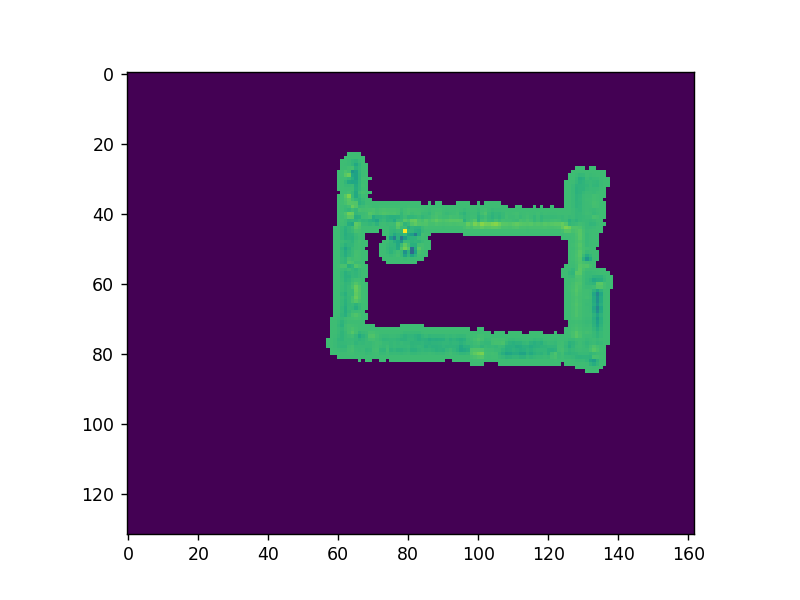

In [15]:
plt.figure()
plt.imshow(mag_x_pred)